# ME 415 - HW6

Eduardo Alvarez

## Aircraft parameters

In [1]:
include("../code/parameters.jl")

Total mass: 0.3536271487697421 (kg)


## Lift-over-drag curve

Since our last design review we shortened the length of the fuselage to about a third, and replaced the vertical tail for winglets. In spite of reducing the fuselage length, we added more weight on electronics, so the total weight ended up being the same, hence, the lift required stayed the same. However, by shortening the fuselage, the parasitic drag was reduced, resulting in the following drag per components and L/D:

<img src="img/drag00.png" alt="Pic here" style="width:700px">
<img src="img/L_over_D00.png" alt="Pic here" style="width:700px">

This increased our max L/D from 10 to about 14, and reduced our cruise speed for optimum L/D from 9.8 m/s to 5.5 m/s.

## Range vs $V_\infty$

Having the following curve for propulsion efficiency vs $V_\infty$:

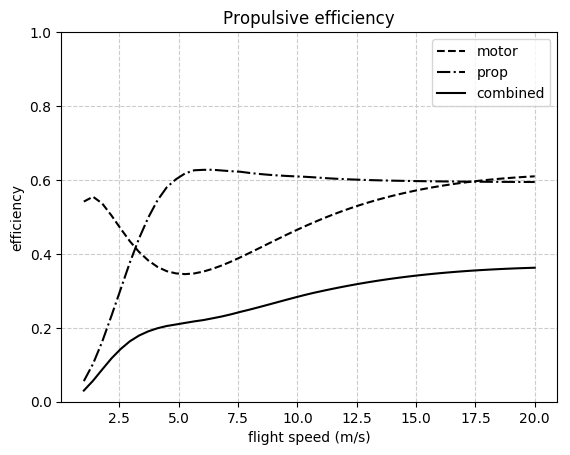

PyObject <matplotlib.text.Text object at 0x7f50ea529710>

In [29]:
include("../415notebooksMOD/motorprop.jl");
# ---- motor, battery, and prop inputs -----

# --- motor ---
Kv = 2760  # (RPM/Volt)
i0 = 0.67  # no load current (Amps)
R = 0.65  # resistance (Ohms)
vbatt = 7.2  # battery voltage (Volts)

# --- prop ----
# propeller data with columns J, CT, CP, eta (same format and normalization as from the UIUC site)
pdata = [
0.056226  0.116461  0.054893  0.119287
0.085145  0.113628  0.054207  0.178478
0.113156  0.110281  0.053396  0.233704
0.140424  0.106085  0.052297  0.284848
0.169910  0.102250  0.051475  0.337510
0.198170  0.098035  0.050457  0.385040
0.226293  0.093316  0.049206  0.429148
0.253961  0.088908  0.048132  0.469108
0.283519  0.083282  0.046435  0.508495
0.311856  0.077415  0.044380  0.543985
0.342100  0.072368  0.043027  0.575394
0.368699  0.066427  0.041051  0.596620
0.397289  0.060631  0.039107  0.615950
0.425618  0.055014  0.037334  0.627177
0.454209  0.048196  0.034881  0.627606
0.482416  0.042382  0.032857  0.622249
0.509778  0.036628  0.030701  0.608186
0.540468  0.029092  0.027795  0.565697
0.566673  0.022170  0.024871  0.505124
0.570499  0.021696  0.025002  0.495058
0.595954  0.015602  0.022588  0.411638
0.624045  0.008996  0.019844  0.282908
0.653165  0.000396  0.016019  0.016152
0.682134 -0.007342  0.012711 -0.394185
0.712493 -0.015583  0.009168 -1.211115
]

D = 4.5 * 0.0254  # prop diamter (m)
rho = 1.225  # atmospheric density (kg/m^3)

# --- operating parameters (one voltage, one flight speed) ---
throttle = 1.0  # number between 0 and 1 - not exactly throttle depending on esc
                # more precisely it is applied voltage relative to battery capacity: v/vbatt

V = 9.8  # flight speed (m/s)
# ------------------------------------------

# ----------- other aircraft inputs ------------
CDp = 0.023  # parasitic drag coefficient
einv = 0.8  # inviscid span efficiency (NOT Oswald efficiency factor, that is computed internally)
# Sref = 0.285  # reference area for CDp (m^2)
b = 1.2  # wing span (m)
nmotors = 2  # number of motors
# mass = 383  # mass of airplane (grams)
mass = Mtot*1000

# plotting parameters
Vmin = 1.0  # m/s
Vmax = 20.0  # m/s
Omegamax = 20000 # RPM (only used to cut off y-scale on last plot.  doesn't affect calculations at all.)
imax = 5.0  # Amp, just for ploting
Tmax = 3.0 # N, just for plotting 
# -----------------------

# run sweep
m = motordef(Kv, i0, R, vbatt)
p = propdef(pdata, D, rho)

ac = acdef(CDp, einv, Sref, b, nmotors, mass)
Vflights, ethas, trusts = steadylevelsweep(m, p, ac, Vmin, Vmax, Omegamax, imax, Tmax; 
                        save_path=nothing, plot_etha=true, plot_trust=false, plot_current=false,
                            plot_omega=false, plot_throttle=false);
title("Propulsive efficiency")

Calculating the range as
<img src="img/range00.png" alt="Pic here" style="width:700px">

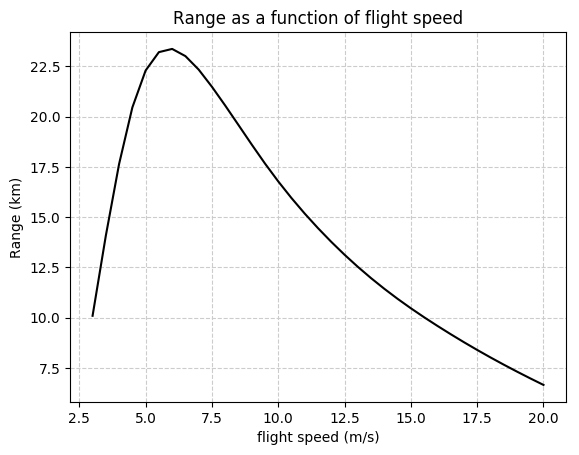

PyObject <matplotlib.text.Text object at 0x7f50ea56e690>

In [30]:
using JLD
using Dierckx

# Battery
b_mAh = 1000 # Battery mAh
b_V = 7.2    # Battery voltage
m_battery = 60/1000; # Mass

# Operation conditions
throttle = 1
voltage = throttle * b_V

# Energy density
energy_density = (b_mAh/1000*60*60) * voltage / m_battery # (J/kg) energy density

# L over D curve
Vinfs, L_over_Ds, Dtots = load("data/L_over_D.jld", "Vinfs", "L_over_Ds", "Dtot_curve")
_spl_L_over_D = Dierckx.Spline1D(Vinfs, L_over_Ds; k=3,s=0.001, bc="error")
spl_L_over_D(Vinf) = Dierckx.evaluate(_spl_L_over_D, Vinf)

# Propulsion efficiency curve
_spl_etha = Dierckx.Spline1D(Vflights, ethas; k=3,s=0.001, bc="error")
spl_etha(Vinf) = Dierckx.evaluate(_spl_etha, Vinf)

# Trust curve (both motors considered)
_spl_trust = Dierckx.Spline1D(Vflights, nmotors*trusts; k=3,s=0.001, bc="error")
spl_trust(Vinf) = Dierckx.evaluate(_spl_trust, Vinf)

# Drag curve
_spl_Dtot = Dierckx.Spline1D(Vinfs, Dtots; k=3,s=0.001, bc="error")
spl_Dtot(Vinf) = Dierckx.evaluate(_spl_Dtot, Vinf)

range_fun(Vinf) = energy_density / g * spl_etha(Vinf) * spl_L_over_D(Vinf) * m_battery/Mtot
ranges = [range_fun(Vinf) for Vinf in Vinfs]
plot(Vinfs, ranges/1000, "k")
xlabel("flight speed (m/s)")
ylabel("Range (km)")
grid(true, color="0.8", linestyle="--")
title("Range as a function of flight speed")

Resulting on a flight speed for max range of 5.8 m/s, and a maximum range of 23 km.

## Endurance vs $V_\infty$

Then, the endurance is calculated as 
<img src="img/endurance00.png" alt="Pic here" style="width:700px">

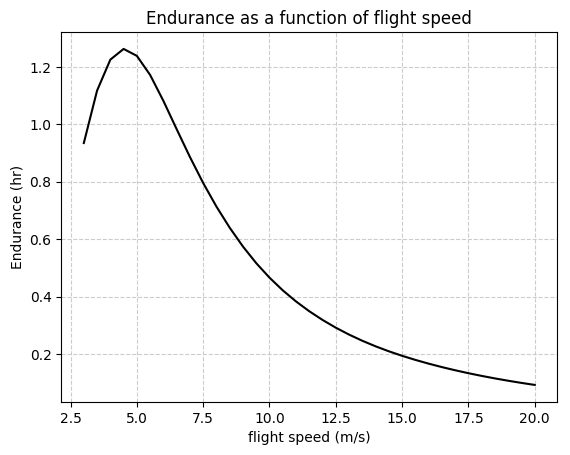

PyObject <matplotlib.text.Text object at 0x7f50ea60e590>

In [31]:
endur_fun(Vinf) = range_fun(Vinf)/Vinf
endurs = [endur_fun(Vinf) for Vinf in Vinfs]
plot(Vinfs, endurs/60/60, "k")
xlabel("flight speed (m/s)")
ylabel("Endurance (hr)")
grid(true, color="0.8", linestyle="--")
title("Endurance as a function of flight speed")

Resulting in a maximum endurance of 1.25 hrs flying at 4.5 m/s. However, this speed is below our minimum flight speed (stall speed), and also, the energy drawn from the battery in that much flight time exceeds the energy available on it. Hence, endurance is not a good performance metric for optimizing our design.

## Climb rate vs $V_\infty$

Having the following thrust vs $V_\infty$ curve for our each of our motors

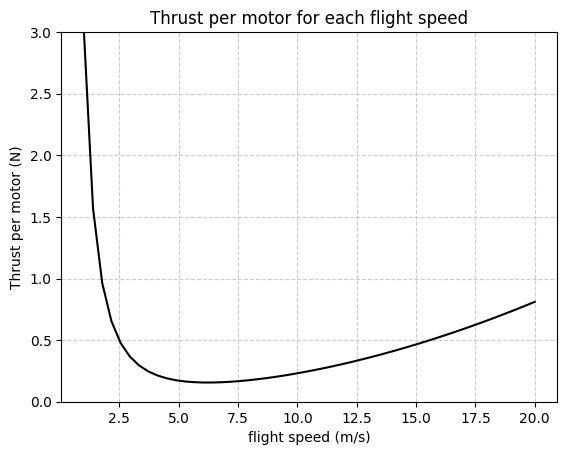

PyObject <matplotlib.text.Text object at 0x7f50ee59e1d0>

In [32]:
_,_,_ = steadylevelsweep(m, p, ac, Vmin, Vmax, Omegamax, imax, Tmax; 
                        save_path=nothing, plot_etha=false, plot_trust=true, plot_current=false,
                            plot_omega=false, plot_throttle=false);
title("Thrust per motor for each flight speed")

and the following drag curve per component

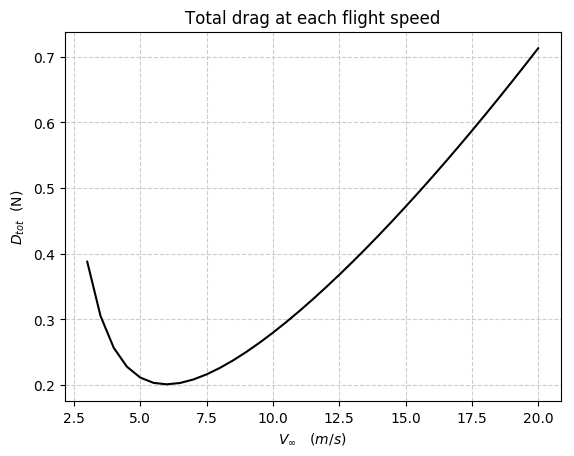

PyObject <matplotlib.text.Text object at 0x7f50eac20cd0>

In [33]:
plot(Vinfs,D_per_component, "k")
grid(true, color="0.8", linestyle="--")
xlabel(L"V_\infty \quad (m/s)")
ylabel(L"$D_{tot} $  (N)")
title("Total drag at each flight speed")


climb rate will be calculated as  
<img src="img/climb00.png" alt="Pic here" style="width:700px">


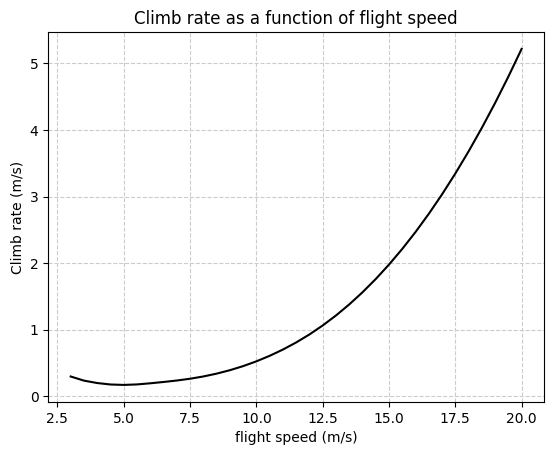

PyObject <matplotlib.text.Text object at 0x7f50ea7c07d0>

In [34]:
climb_rate_fun(Vinf) = Vinf * (spl_trust(Vinf) - spl_Dtot(Vinf)) / (Mtot*g)
climb_rates = [climb_rate_fun(Vinf) for Vinf in Vinfs]
plot(Vinfs, climb_rates, "k")
xlabel("flight speed (m/s)")
ylabel("Climb rate (m/s)")
grid(true, color="0.8", linestyle="--")
title("Climb rate as a function of flight speed")

Resulted in a climb rate that is unbounded, meaning that it keeps growing with the flight speed.

## Discussion

From the previous analysis it was determined that the flight speed of optimum $L/D$ is 5.5 m/s with $(L/D)_{\text{max}} = 14$;  a flight speed for max range of 5.8 m/s at a range of 23 km; a flight speed for max endurange of 4.5 m/s at an endurance of 1.25 hrs; and a climb rate that grows with flight speed. Since the flight speed for max endurance is below our stall speed, and the climb rate is unbounded, it is convenient to match our design speed with the speed of maximum range, which is 5.8 m/s, making range our performance metric. At this design speed, the maximum range of our airplane will be 23 km, its endurance will be about 1 hr, its climb rate will be 0.2 m/s, and a $L/D$ of 14. To achieve a feasible climb rate, the airplane will need to speed up to about 12.5 m/s for a climb rate of 1 m/s when climbing is needed. 

This design speed results in the following coefficient of lift:

In [37]:
design_V = 5.8
design_CL = L / calc_qinf(design_V) / Sref
println("CL = $design_CL")

CL = 0.5913575515004375


## Build report

* **How much time you personally spent working on building/flying:** 4 hrs.
* **What you personally accomplished:** I worked on assembling the fuselage, making the wiring for the electronics, and mount servos to actuate control surfaces.
* **An overview of what the team accomplished, lessons learned, and areas for future improvement**: After assembling the fuselage we realized that it adds a lot of unnecessary weight to our aircraft, so we reduced its length to about a third of its original length, and adding a boom to support our canard. Also we realized that we would need landing gear, so we tapped and reinforced the bottom of our wing and canard to withstand scratching the ground during landing. Also we got rid of the vertical tail and switched to a winglet-rudder configuration.
* **Photo(s) of the aircraft on the ground**: 



<img src="img/build00.jpg" alt="Pic here" style="width:700px">